In [10]:
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader

import numpy as np
import pandas as pd

from model_code.ADFA_model_sigmoid import *
from model_code.NGIDS_model import *
from model_code.Discriminator_sigmoid import *

from sklearn.model_selection import train_test_split
from model_code.ignite_trainer_sigmoid import MyTrainer


from collections import OrderedDict
import time


%load_ext autoreload
%autoreload 2

import os, sys
sys.path.append(os.path.dirname(os.path.abspath(os.curdir)))

cuda = torch.device('cuda') # GPU 사용

# hyper parameter

# gensim
word_vector_size = 20
window_size = 1

# LSTM
adfa_batch_size = 256
n_step = 3 # 1~3
n_hidden = 64 # 8~64
LearningRate = 0.01 # 0.01~0.001
max_epoch = 400
drop_out = 0.5 #0.2~0.5
patience = 20 

# ADDA
ngids_batch_size = 256
D_NGIDS_train_num = 1
adda_max_epoch = 50
adda_LearningRate = 0.0002

dates="6_19"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Gensim 모델 구축


In [2]:
from model_code.ADFA_NGIDS_gensim import NGIDS_word2vec, ADFA_word2vec

NGIDS_word2vec_model = NGIDS_word2vec('./dataset/NGIDS_host_log_1-99.csv')
NGIDS_word2vec_model.make_vector(word_vector_size, save_path='./NGIDS_word2vec_'+str(word_vector_size)+'.model')

ADFA_word2vec_model = ADFA_word2vec('./dataset/ADFA-LD/')
ADFA_word2vec_model.make_vector(word_vector_size, save_path='./ADFA_word2vec_'+str(word_vector_size)+'.model')

KeyboardInterrupt: 

### Gensim 모델 로드


In [11]:
import gensim

ADFA_word_model = gensim.models.Word2Vec.load('./ADFA_word2vec_'+str(word_vector_size)+'.model')
NGIDS_word_model = gensim.models.Word2Vec.load('./NGIDS_word2vec_'+str(word_vector_size)+'.model')

### 데이터 로드

In [12]:
def collate_fn(batch):

    x, y = zip(*batch)

    l = [len(i) for i in x]

    (l, i, t) = zip(*sorted(((l[i], i, (x[i], y[i])) for i in range(len(x))), reverse=True))
    (x, y) = zip(*t)

    l = torch.tensor(l)
    pack = nn.utils.rnn.pad_sequence(x, batch_first=True).to(cuda)
    y = torch.stack(y).to(cuda)

    return ((l, pack), y)

import pickle, gzip

slices = 111
X_train_add = "./shuffle_datas/ADFA_X_train_"+str(slices)+"_6_02.pkl"
y_train_add = "./shuffle_datas/ADFA_y_train_"+str(slices)+"_6_02.pkl"

X_vali_add = "./shuffle_datas/ADFA_X_vali_"+str(slices)+"_6_02.pkl"
y_vali_add = "./shuffle_datas/ADFA_y_vali_"+str(slices)+"_6_02.pkl"

X_test_add = "./shuffle_datas/ADFA_X_test_"+str(slices)+"_6_02.pkl"
y_test_add = "./shuffle_datas/ADFA_y_test_"+str(slices)+"_6_02.pkl"

def load_data(X_add, y_add):
    with gzip.open(X_add, 'rb') as f:
        X = pickle.load(f)
    with gzip.open(y_add, 'rb') as f:
        y = pickle.load(f)
    return X, y

def preprocess_y(y_data):
    label_dict = dict()
    for i in range(8):
        if i == 0:
            label_dict[i] = 0
        else:
            label_dict[i] = 1
#     tmp = np.argmax(y_data, axis=1)
    tmp = pd.Series(y_data).map(label_dict).values
    return np.asarray(tmp)

X_train, y_train = load_data(X_train_add, y_train_add)
X_vali, y_vali = load_data(X_vali_add, y_vali_add)
X_test, y_test = load_data(X_test_add, y_test_add)
y_train = preprocess_y(y_train)
y_vali = preprocess_y(y_vali)
y_test = preprocess_y(y_test)

ADFA_loader = DataLoader(ADFA_Dataset(X_train, y_train, ADFA_word_model.wv.key_to_index), 
                         batch_size=adfa_batch_size, collate_fn=collate_fn, shuffle = True)
ADFA_test_loader = DataLoader(ADFA_Dataset(X_test, y_test, ADFA_word_model.wv.key_to_index), 
                              batch_size=adfa_batch_size, collate_fn=collate_fn, shuffle = True)
ADFA_vali_loader = DataLoader(ADFA_Dataset(X_vali, y_vali, ADFA_word_model.wv.key_to_index), 
                              batch_size=adfa_batch_size, collate_fn=collate_fn, shuffle = True)

NGIDS_reader = NGIDS_Reader()
n_X_train, n_y_train, n_X_vali, n_y_vali, n_X_test, n_y_test = NGIDS_reader.data_split()

NGIDS_train_loader = DataLoader(NGIDS_Dataset(n_X_train, n_y_train, NGIDS_word_model.wv.key_to_index), 
                          batch_size=ngids_batch_size, collate_fn=collate_fn, shuffle = True)
NGIDS_vali_loader = DataLoader(NGIDS_Dataset(n_X_vali, n_y_vali, NGIDS_word_model.wv.key_to_index), 
                               batch_size=ngids_batch_size, collate_fn=collate_fn)
NGIDS_test_loader = DataLoader(NGIDS_Dataset(n_X_test, n_y_test, NGIDS_word_model.wv.key_to_index), 
                               batch_size=ngids_batch_size, collate_fn=collate_fn)

KeyboardInterrupt: 

Training Results - Epoch[1]
Loss: 0.3180
Accuracy: 0.8753
Precision: 0.0000
Recall: 0.0000
ROC_AUC: 0.7795

Validation Results - Epoch[1]
Loss: 0.3245
Accuracy: 0.8749
Precision: 0.0000
Recall: 0.0000
ROC_AUC: 0.7639

Training Results - Epoch[2]
Loss: 0.3346
Accuracy: 0.8753
Precision: 0.0000
Recall: 0.0000
ROC_AUC: 0.8323

Validation Results - Epoch[2]
Loss: 0.3351
Accuracy: 0.8749
Precision: 0.0000
Recall: 0.0000
ROC_AUC: 0.8238

Training Results - Epoch[3]
Loss: 0.2395
Accuracy: 0.8753
Precision: 0.0000
Recall: 0.0000
ROC_AUC: 0.9105

Validation Results - Epoch[3]
Loss: 0.2388
Accuracy: 0.8749
Precision: 0.0000
Recall: 0.0000
ROC_AUC: 0.9081

Training Results - Epoch[4]
Loss: 0.5031
Accuracy: 0.8753
Precision: 0.0000
Recall: 0.0000
ROC_AUC: 0.7924

Validation Results - Epoch[4]
Loss: 0.5046
Accuracy: 0.8749
Precision: 0.0000
Recall: 0.0000
ROC_AUC: 0.7949

Training Results - Epoch[5]
Loss: 0.2890
Accuracy: 0.8753
Precision: 0.0000
Recall: 0.0000
ROC_AUC: 0.8503

Validation Results -

Validation Results - Epoch[38]
Loss: 0.1582
Accuracy: 0.9471
Precision: 0.7312
Recall: 0.9128
ROC_AUC: 0.9720

Training Results - Epoch[39]
Loss: 0.0986
Accuracy: 0.9588
Precision: 0.7980
Recall: 0.8966
ROC_AUC: 0.9881

Validation Results - Epoch[39]
Loss: 0.1286
Accuracy: 0.9488
Precision: 0.7651
Recall: 0.8523
ROC_AUC: 0.9742

Training Results - Epoch[40]
Loss: 0.0921
Accuracy: 0.9610
Precision: 0.8174
Recall: 0.8854
ROC_AUC: 0.9888

Validation Results - Epoch[40]
Loss: 0.1236
Accuracy: 0.9597
Precision: 0.7919
Recall: 0.9195
ROC_AUC: 0.9774

Training Results - Epoch[41]
Loss: 0.0809
Accuracy: 0.9678
Precision: 0.8750
Recall: 0.8652
ROC_AUC: 0.9908

Validation Results - Epoch[41]
Loss: 0.1131
Accuracy: 0.9589
Precision: 0.8378
Recall: 0.8322
ROC_AUC: 0.9791

Training Results - Epoch[42]
Loss: 0.0752
Accuracy: 0.9728
Precision: 0.8686
Recall: 0.9213
ROC_AUC: 0.9927

Validation Results - Epoch[42]
Loss: 0.1205
Accuracy: 0.9513
Precision: 0.7862
Recall: 0.8389
ROC_AUC: 0.9778

Training 

Training Results - Epoch[76]
Loss: 0.0549
Accuracy: 0.9781
Precision: 0.8946
Recall: 0.9348
ROC_AUC: 0.9971

Validation Results - Epoch[76]
Loss: 0.1228
Accuracy: 0.9664
Precision: 0.8344
Recall: 0.9128
ROC_AUC: 0.9834

Training Results - Epoch[77]
Loss: 0.0582
Accuracy: 0.9739
Precision: 0.9632
Recall: 0.8225
ROC_AUC: 0.9957

Validation Results - Epoch[77]
Loss: 0.1153
Accuracy: 0.9664
Precision: 0.8811
Recall: 0.8456
ROC_AUC: 0.9842

Training Results - Epoch[78]
Loss: 0.0560
Accuracy: 0.9809
Precision: 0.9180
Recall: 0.9303
ROC_AUC: 0.9964

Validation Results - Epoch[78]
Loss: 0.1139
Accuracy: 0.9656
Precision: 0.8176
Recall: 0.9329
ROC_AUC: 0.9855

Training Results - Epoch[79]
Loss: 0.0504
Accuracy: 0.9795
Precision: 0.9009
Recall: 0.9393
ROC_AUC: 0.9971

Validation Results - Epoch[79]
Loss: 0.1182
Accuracy: 0.9614
Precision: 0.8160
Recall: 0.8926
ROC_AUC: 0.9836

Training Results - Epoch[80]
Loss: 0.0520
Accuracy: 0.9773
Precision: 0.9333
Recall: 0.8809
ROC_AUC: 0.9966

Validation 

2022-06-19 14:28:33,087 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


Validation Results - Epoch[94]
Loss: 0.1103
Accuracy: 0.9622
Precision: 0.8171
Recall: 0.8993
ROC_AUC: 0.9850



2022-06-19 14:28:33,728 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


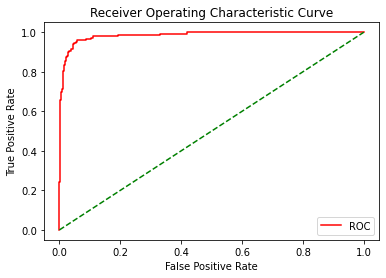

FileNotFoundError: [Errno 2] No such file or directory: './result_image/lstm_weight_share_ADFA_sig_111_20d001LR_05Drop_epoch400_ignite_6_19_ws_1_layer_3.png'

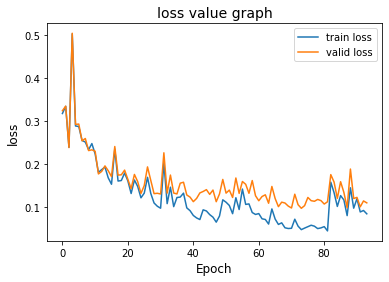

In [4]:
ADFA_model = nn.Sequential(OrderedDict([
            ('ADFA_LSTM', ADFA_LSTM(word_vector_size, ADFA_word_model.wv.vectors, n_hidden, n_step, dropout_p = drop_out)),
            ('ADFA_LINEAR', ADFA_LINEAR(n_hidden))
            ])).cuda()

optimizer = optim.Adam(ADFA_model.parameters(), lr=LearningRate)
loss_func = nn.BCELoss() 

trainer = MyTrainer(ADFA_model, optimizer, loss_func, ADFA_loader, ADFA_vali_loader, patience)

trainer.run(max_epoch)

trainer.print_loss_graph("./result_image/lstm_weight_share_ADFA_sig_"+str(slices)+"_"+str(word_vector_size)+"d"+str(LearningRate).replace(".", "")+"LR_"+str(drop_out).replace(".","")+"Drop"+"_epoch"+str(max_epoch)+"_ignite_"+dates+"_ws_"+str(window_size)+"_layer_"+str(n_step))
torch.save(ADFA_model.state_dict(), "./lstm_weight_share_ADFA_sig_"+str(slices)+"_"+str(word_vector_size)+"d"+str(LearningRate).replace(".", "")+"LR_"+str(drop_out).replace(".","")+"Drop"+"_epoch"+str(max_epoch)+"_ignite_"+dates+"_ws_"+str(window_size)+"_layer_"+str(n_step)+"_model.model")


### 2번째 ADDA 단계 학습

In [8]:
from sklearn.metrics import roc_auc_score, roc_curve


def plot_roc_curve(fper, tper):
    plt.plot(fper, tper, color='red', label='ROC')
    plt.plot([0, 1], [0, 1], color='green', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend()
    plt.show()
    
def G_epoch_eval(G, ADFA_model, NGIDS_test_loader):
    
    ADFA_Classifier = ADFA_model.get_submodule('ADFA_LINEAR')

    G.eval()
    ADFA_Classifier.eval()
    
    model = nn.Sequential(G, ADFA_Classifier).cuda()

    TP = 0
    FP = 0
    FN = 0
    TN = 0

    labels = torch.tensor([]).to(cuda)
    outs = torch.tensor([]).to(cuda)

    with torch.no_grad():

         for iidx, i in enumerate(NGIDS_test_loader):
            batch_x, batch_y = i
            
            out = model(batch_x)
            
            labels = torch.concat((labels, batch_y))
            outs = torch.concat((outs, out))           

            for idx, j in enumerate(out) :

                if j < 0.5:
                    result = 0
                else :
                    result = 1

                if batch_y[idx] == 1:
                    if result == 1:
                        TP += 1
                    else :
                        FN += 1                        
                else :
                    if result == 1 :
                        FP += 1
                    else :
                        TN += 1

    labels = labels.detach().cpu().numpy()
    outs = outs.detach().cpu().numpy()

    try :
        accuracy = (TP + TN)/(TP + FN + FP + TN)
        recall = TP/(FN+TP)
        precision = TP/(FP+TP)
        f1= 2 * (precision * recall) / (precision + recall)
        
        rascore = roc_auc_score(labels, outs)
        fpr, tpr, thresholds = roc_curve(labels, outs)
        
        plot_roc_curve(fpr, tpr)
        
    except ZeroDivisionError :
        accuracy = 0
        recall = 0
        precision = 0
        rascore = 0
        f1 = 0
        pass
    
#     accuracy = (TP + TN)/(TP + FN + FP + TN)
#     recall = TP/(FN+TP)
#     precision = TP/(FP+TP)
#     f1= 2 * (precision * recall) / (precision + recall)

    print(f"Test accuacy : {accuracy}")
    print(f"Test Recall : {recall}")
    print(f"Test precision : {precision}")
    print(f"Test f1-score : {f1}")
    print(f"Test ROC_AUC Score : {rascore}")
    
    return recall

epoch =  1
D_loss : 0.6316 / G_loss : 0.7305


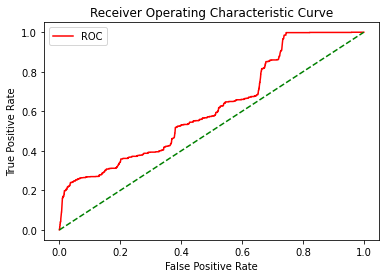

Test accuacy : 0.054051250129681504
Test Recall : 1.0
Test precision : 0.054051250129681504
Test f1-score : 0.10255905511811024
Test ROC_AUC Score : 0.6211988825124546
Time(s): 127.34674549102783
epoch =  2
D_loss : 0.6458 / G_loss : 0.6888


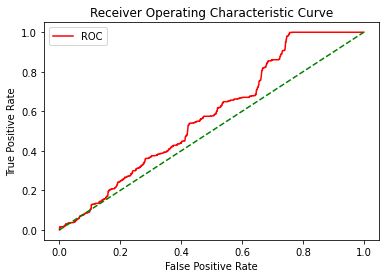

Test accuacy : 0.054051250129681504
Test Recall : 1.0
Test precision : 0.054051250129681504
Test f1-score : 0.10255905511811024
Test ROC_AUC Score : 0.5791408780337474
Time(s): 254.64305114746094
epoch =  3
D_loss : 0.6485 / G_loss : 0.6772


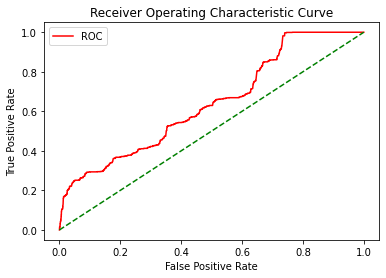

Test accuacy : 0.054051250129681504
Test Recall : 1.0
Test precision : 0.054051250129681504
Test f1-score : 0.10255905511811024
Test ROC_AUC Score : 0.6410119939509245
Time(s): 382.716983795166
epoch =  4
D_loss : 0.6481 / G_loss : 0.6735


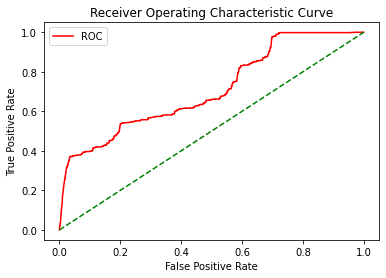

Test accuacy : 0.054051250129681504
Test Recall : 1.0
Test precision : 0.054051250129681504
Test f1-score : 0.10255905511811024
Test ROC_AUC Score : 0.7102206609524346
Time(s): 511.4679319858551
epoch =  5
D_loss : 0.6461 / G_loss : 0.6748


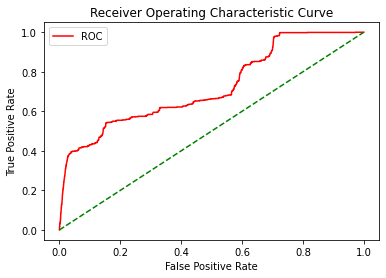

Test accuacy : 0.054051250129681504
Test Recall : 1.0
Test precision : 0.054051250129681504
Test f1-score : 0.10255905511811024
Test ROC_AUC Score : 0.7229114628043747
Time(s): 639.0831687450409
epoch =  6
D_loss : 0.6453 / G_loss : 0.6747


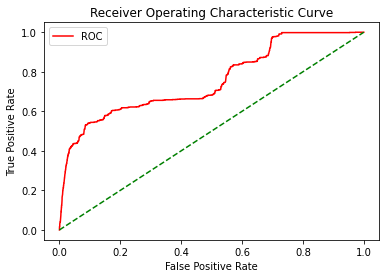

Test accuacy : 0.054051250129681504
Test Recall : 1.0
Test precision : 0.054051250129681504
Test f1-score : 0.10255905511811024
Test ROC_AUC Score : 0.7552991772617408
Time(s): 766.1974444389343
epoch =  7
D_loss : 0.6461 / G_loss : 0.6722


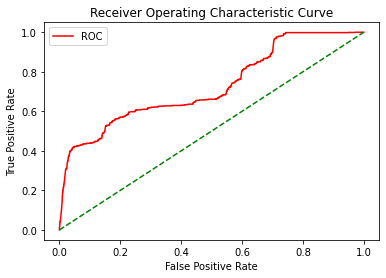

Test accuacy : 0.054051250129681504
Test Recall : 1.0
Test precision : 0.054051250129681504
Test f1-score : 0.10255905511811024
Test ROC_AUC Score : 0.7278201530456514
Time(s): 892.740184545517
epoch =  8
D_loss : 0.6455 / G_loss : 0.6719


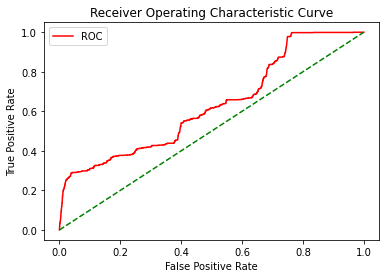

Test accuacy : 0.054051250129681504
Test Recall : 1.0
Test precision : 0.054051250129681504
Test f1-score : 0.10255905511811024
Test ROC_AUC Score : 0.6317452422682517
Time(s): 1019.4349610805511
epoch =  9
D_loss : 0.6434 / G_loss : 0.6739


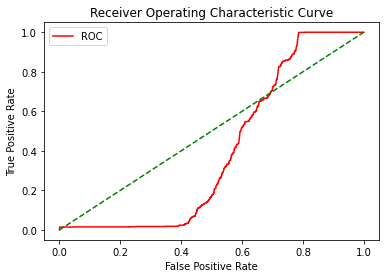

Test accuacy : 0.054051250129681504
Test Recall : 1.0
Test precision : 0.054051250129681504
Test f1-score : 0.10255905511811024
Test ROC_AUC Score : 0.39673036587055033
Time(s): 1142.052515745163
epoch =  10
D_loss : 0.6410 / G_loss : 0.6756


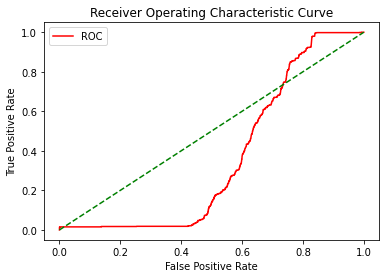

Test accuacy : 0.054051250129681504
Test Recall : 1.0
Test precision : 0.054051250129681504
Test f1-score : 0.10255905511811024
Test ROC_AUC Score : 0.3639714519254694
Time(s): 1271.18616938591
epoch =  11
D_loss : 0.6378 / G_loss : 0.6765


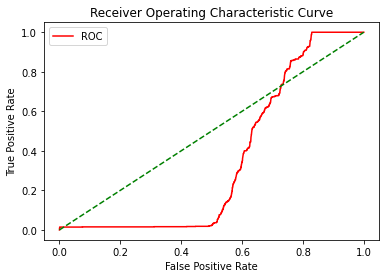

Test accuacy : 0.054051250129681504
Test Recall : 1.0
Test precision : 0.054051250129681504
Test f1-score : 0.10255905511811024
Test ROC_AUC Score : 0.3532581089734549
Time(s): 1396.5318882465363
epoch =  12
D_loss : 0.6359 / G_loss : 0.6753


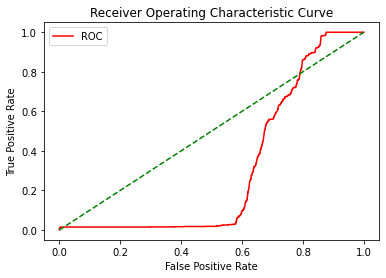

Test accuacy : 0.054051250129681504
Test Recall : 1.0
Test precision : 0.054051250129681504
Test f1-score : 0.10255905511811024
Test ROC_AUC Score : 0.30847308944489377
Time(s): 1522.8228142261505
epoch =  13
D_loss : 0.6381 / G_loss : 0.6659


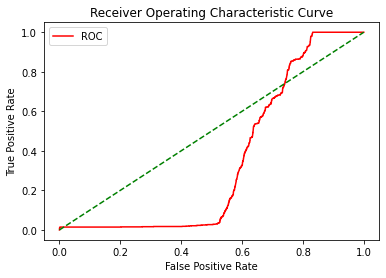

Test accuacy : 0.054051250129681504
Test Recall : 1.0
Test precision : 0.054051250129681504
Test f1-score : 0.10255905511811024
Test ROC_AUC Score : 0.3501460537234359
Time(s): 1650.603562116623
epoch =  14
D_loss : 0.6411 / G_loss : 0.6573


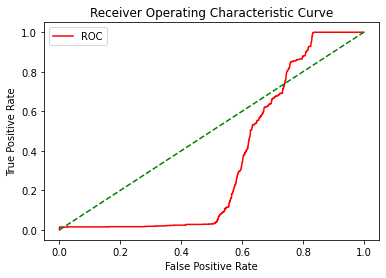

Test accuacy : 0.054051250129681504
Test Recall : 1.0
Test precision : 0.054051250129681504
Test f1-score : 0.10255905511811024
Test ROC_AUC Score : 0.3525725726968949
Time(s): 1777.0305199623108
epoch =  15
D_loss : 0.6393 / G_loss : 0.6629


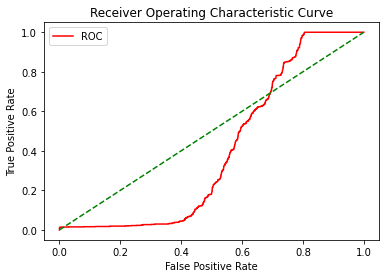

Test accuacy : 0.054051250129681504
Test Recall : 1.0
Test precision : 0.054051250129681504
Test f1-score : 0.10255905511811024
Test ROC_AUC Score : 0.40047946227726977
Time(s): 1904.1792993545532
epoch =  16
D_loss : 0.6369 / G_loss : 0.6703


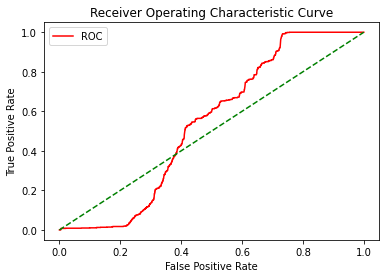

Test accuacy : 0.054051250129681504
Test Recall : 1.0
Test precision : 0.054051250129681504
Test f1-score : 0.10255905511811024
Test ROC_AUC Score : 0.5344129053960465
Time(s): 2029.9661393165588
epoch =  17
D_loss : 0.6401 / G_loss : 0.6642


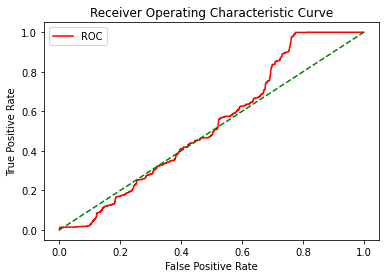

Test accuacy : 0.054051250129681504
Test Recall : 1.0
Test precision : 0.054051250129681504
Test f1-score : 0.10255905511811024
Test ROC_AUC Score : 0.531320295557626
Time(s): 2156.9317483901978
epoch =  18
D_loss : 0.6417 / G_loss : 0.6588


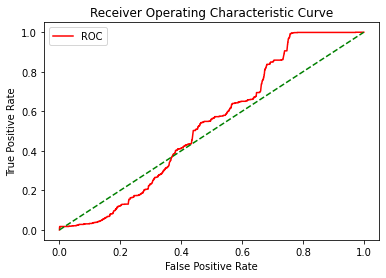

Test accuacy : 0.054051250129681504
Test Recall : 1.0
Test precision : 0.054051250129681504
Test f1-score : 0.10255905511811024
Test ROC_AUC Score : 0.5334512390121584
Time(s): 2282.8364346027374
epoch =  19
D_loss : 0.6400 / G_loss : 0.6603


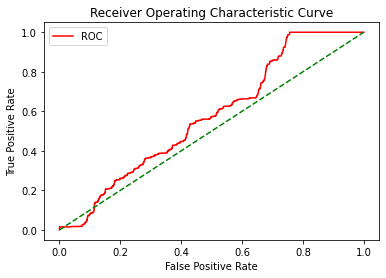

Test accuacy : 0.054051250129681504
Test Recall : 1.0
Test precision : 0.054051250129681504
Test f1-score : 0.10255905511811024
Test ROC_AUC Score : 0.5745108965876697
Time(s): 2408.769326210022
epoch =  20
D_loss : 0.6398 / G_loss : 0.6596


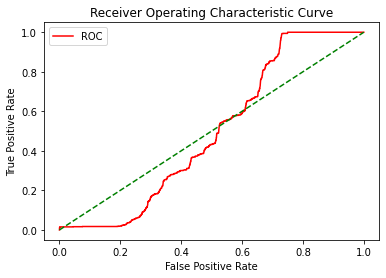

Test accuacy : 0.054051250129681504
Test Recall : 1.0
Test precision : 0.054051250129681504
Test f1-score : 0.10255905511811024
Test ROC_AUC Score : 0.49342381966614735
Time(s): 2535.448973417282
epoch =  21
D_loss : 0.6395 / G_loss : 0.6569


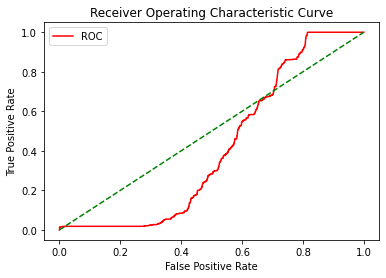

Test accuacy : 0.054051250129681504
Test Recall : 1.0
Test precision : 0.054051250129681504
Test f1-score : 0.10255905511811024
Test ROC_AUC Score : 0.41327767437297885
Time(s): 2662.893270254135
epoch =  22
D_loss : 0.6379 / G_loss : 0.6555


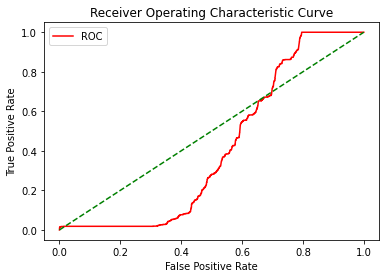

Test accuacy : 0.054051250129681504
Test Recall : 1.0
Test precision : 0.054051250129681504
Test f1-score : 0.10255905511811024
Test ROC_AUC Score : 0.4125029365465959
Time(s): 2790.0086212158203
epoch =  23
D_loss : 0.6363 / G_loss : 0.6547


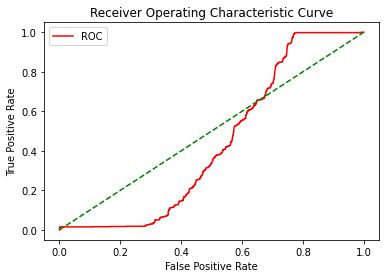

Test accuacy : 0.054051250129681504
Test Recall : 1.0
Test precision : 0.054051250129681504
Test f1-score : 0.10255905511811024
Test ROC_AUC Score : 0.4369597648910278
Time(s): 2916.7196431159973
epoch =  24
D_loss : 0.6353 / G_loss : 0.6533


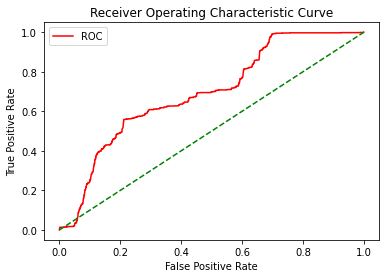

Test accuacy : 0.054051250129681504
Test Recall : 1.0
Test precision : 0.054051250129681504
Test f1-score : 0.10255905511811024
Test ROC_AUC Score : 0.6936025700992615
Time(s): 3046.087771177292
epoch =  25
D_loss : 0.6385 / G_loss : 0.6455


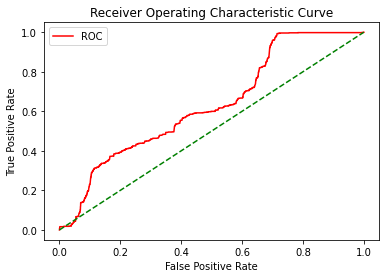

Test accuacy : 0.054051250129681504
Test Recall : 1.0
Test precision : 0.054051250129681504
Test f1-score : 0.10255905511811024
Test ROC_AUC Score : 0.6325354785350021
Time(s): 3173.696254968643
epoch =  26
D_loss : 0.6437 / G_loss : 0.6396


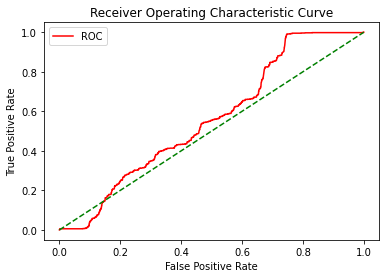

Test accuacy : 0.054051250129681504
Test Recall : 1.0
Test precision : 0.054051250129681504
Test f1-score : 0.10255905511811024
Test ROC_AUC Score : 0.5602706453961054
Time(s): 3301.770280599594
epoch =  27
D_loss : 0.6408 / G_loss : 0.6545


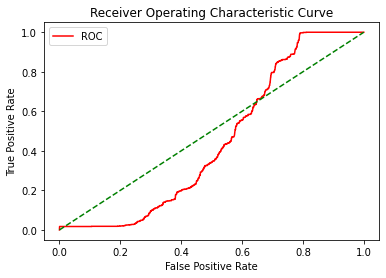

Test accuacy : 0.054051250129681504
Test Recall : 1.0
Test precision : 0.054051250129681504
Test f1-score : 0.10255905511811024
Test ROC_AUC Score : 0.44552987615141043
Time(s): 3430.5911271572113
epoch =  28
D_loss : 0.6370 / G_loss : 0.6702


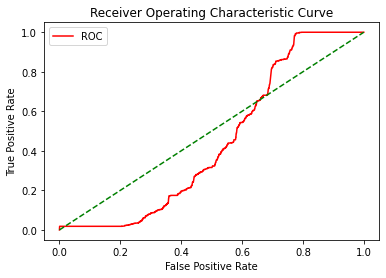

Test accuacy : 0.054051250129681504
Test Recall : 1.0
Test precision : 0.054051250129681504
Test f1-score : 0.10255905511811024
Test ROC_AUC Score : 0.44493030490826396
Time(s): 3557.0986528396606
epoch =  29
D_loss : 0.6390 / G_loss : 0.6668


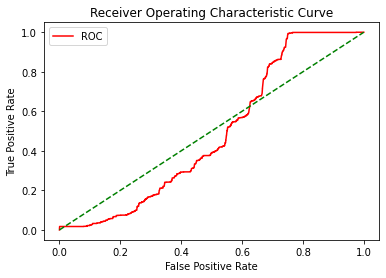

Test accuacy : 0.054051250129681504
Test Recall : 1.0
Test precision : 0.054051250129681504
Test f1-score : 0.10255905511811024
Test ROC_AUC Score : 0.4854550426293943
Time(s): 3685.3633658885956
epoch =  30
D_loss : 0.6386 / G_loss : 0.6602


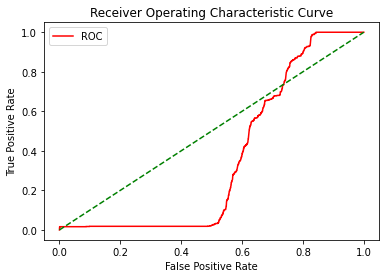

Test accuacy : 0.054051250129681504
Test Recall : 1.0
Test precision : 0.054051250129681504
Test f1-score : 0.10255905511811024
Test ROC_AUC Score : 0.35828762916068657
Time(s): 3812.6529433727264
epoch =  31
D_loss : 0.6384 / G_loss : 0.6517


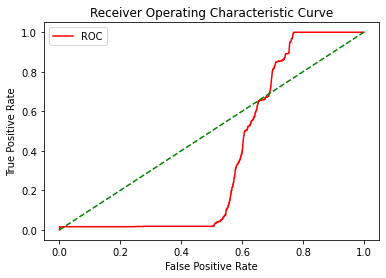

Test accuacy : 0.054051250129681504
Test Recall : 1.0
Test precision : 0.054051250129681504
Test f1-score : 0.10255905511811024
Test ROC_AUC Score : 0.3759481940554193
Time(s): 3940.598083972931
epoch =  32
D_loss : 0.6402 / G_loss : 0.6436


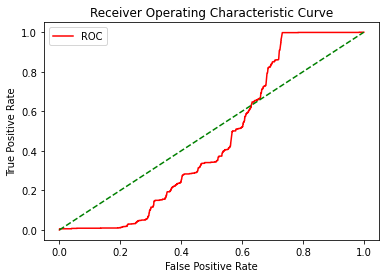

Test accuacy : 0.054051250129681504
Test Recall : 1.0
Test precision : 0.054051250129681504
Test f1-score : 0.10255905511811024
Test ROC_AUC Score : 0.46063706641731633
Time(s): 4066.5450241565704
epoch =  33
D_loss : 0.6421 / G_loss : 0.6391


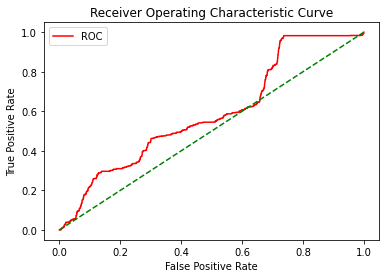

Test accuacy : 0.054051250129681504
Test Recall : 1.0
Test precision : 0.054051250129681504
Test f1-score : 0.10255905511811024
Test ROC_AUC Score : 0.5914005127484013
Time(s): 4196.115505456924
epoch =  34
D_loss : 0.6417 / G_loss : 0.6438


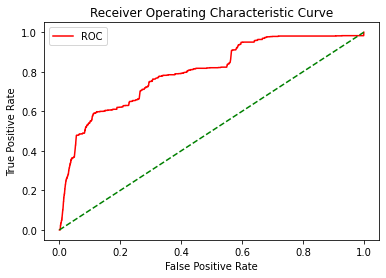

Test accuacy : 0.054051250129681504
Test Recall : 1.0
Test precision : 0.054051250129681504
Test f1-score : 0.10255905511811024
Test ROC_AUC Score : 0.7990513007322633
Time(s): 4322.636362314224
epoch =  35
D_loss : 0.6387 / G_loss : 0.6571


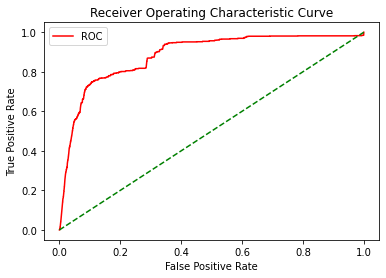

Test accuacy : 0.054051250129681504
Test Recall : 1.0
Test precision : 0.054051250129681504
Test f1-score : 0.10255905511811024
Test ROC_AUC Score : 0.8834362299962235
Time(s): 4448.907679080963
epoch =  36
D_loss : 0.6381 / G_loss : 0.6649


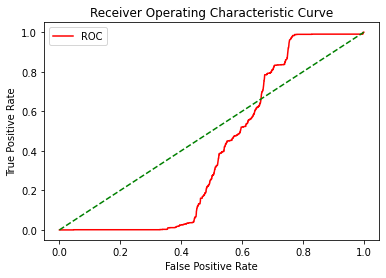

Test accuacy : 0.054051250129681504
Test Recall : 1.0
Test precision : 0.054051250129681504
Test f1-score : 0.10255905511811024
Test ROC_AUC Score : 0.4071804195283085
Time(s): 4573.7283256053925
epoch =  37
D_loss : 0.6393 / G_loss : 0.6611


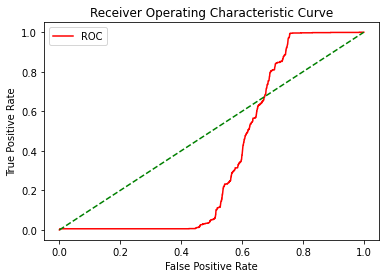

Test accuacy : 0.054051250129681504
Test Recall : 1.0
Test precision : 0.054051250129681504
Test f1-score : 0.10255905511811024
Test ROC_AUC Score : 0.3785792713912158
Time(s): 4701.0196306705475
epoch =  38
D_loss : 0.6372 / G_loss : 0.6587


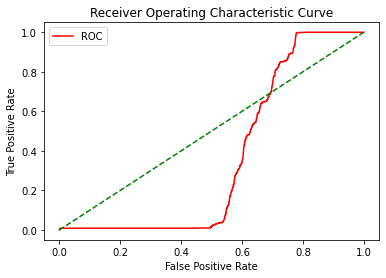

Test accuacy : 0.054051250129681504
Test Recall : 1.0
Test precision : 0.054051250129681504
Test f1-score : 0.10255905511811024
Test ROC_AUC Score : 0.3643475193443691
Time(s): 4830.130486488342
epoch =  39
D_loss : 0.6375 / G_loss : 0.6515


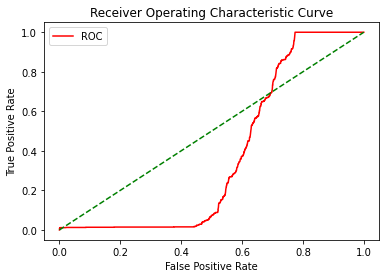

Test accuacy : 0.054051250129681504
Test Recall : 1.0
Test precision : 0.054051250129681504
Test f1-score : 0.10255905511811024
Test ROC_AUC Score : 0.37559130891670267
Time(s): 4956.230320215225
epoch =  40
D_loss : 0.6426 / G_loss : 0.6366


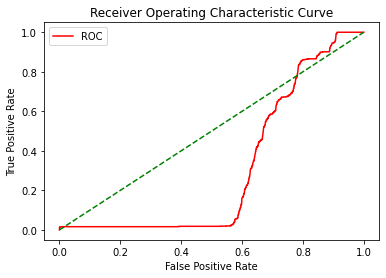

Test accuacy : 0.054051250129681504
Test Recall : 1.0
Test precision : 0.054051250129681504
Test f1-score : 0.10255905511811024
Test ROC_AUC Score : 0.3106464233704482
Time(s): 5084.732105731964
epoch =  41
D_loss : 0.6445 / G_loss : 0.6298


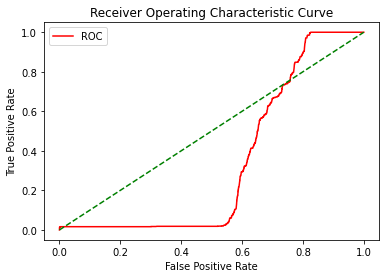

Test accuacy : 0.054051250129681504
Test Recall : 1.0
Test precision : 0.054051250129681504
Test f1-score : 0.10255905511811024
Test ROC_AUC Score : 0.3397154981035593
Time(s): 5213.302375555038
epoch =  42
D_loss : 0.6425 / G_loss : 0.6328


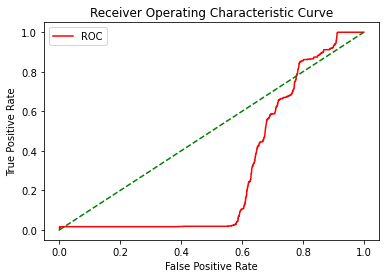

Test accuacy : 0.054051250129681504
Test Recall : 1.0
Test precision : 0.054051250129681504
Test f1-score : 0.10255905511811024
Test ROC_AUC Score : 0.30715248549724894
Time(s): 5340.859060287476
epoch =  43
D_loss : 0.6409 / G_loss : 0.6374


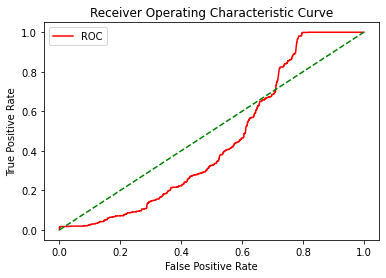

Test accuacy : 0.054051250129681504
Test Recall : 1.0
Test precision : 0.054051250129681504
Test f1-score : 0.10255905511811024
Test ROC_AUC Score : 0.44829444005424296
Time(s): 5468.289576768875
epoch =  44
D_loss : 0.6402 / G_loss : 0.6412


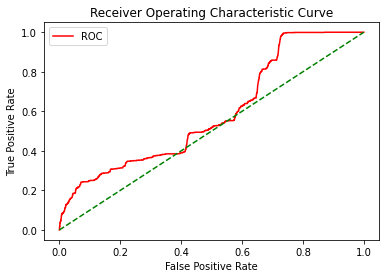

Test accuacy : 0.054051250129681504
Test Recall : 1.0
Test precision : 0.054051250129681504
Test f1-score : 0.10255905511811024
Test ROC_AUC Score : 0.592284055415055
Time(s): 5595.534288406372
epoch =  45
D_loss : 0.6403 / G_loss : 0.6426


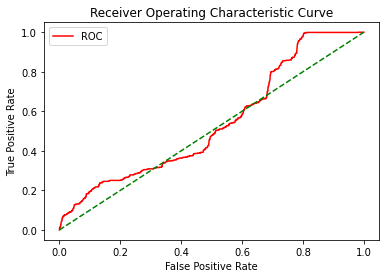

Test accuacy : 0.054051250129681504
Test Recall : 1.0
Test precision : 0.054051250129681504
Test f1-score : 0.10255905511811024
Test ROC_AUC Score : 0.5419156503829721
Time(s): 5722.372953891754
epoch =  46
D_loss : 0.6408 / G_loss : 0.6419


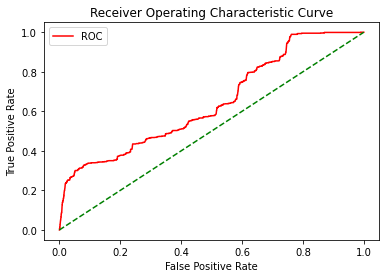

Test accuacy : 0.054051250129681504
Test Recall : 1.0
Test precision : 0.054051250129681504
Test f1-score : 0.10255905511811024
Test ROC_AUC Score : 0.6454514945653891
Time(s): 5850.351083040237
epoch =  47
D_loss : 0.6410 / G_loss : 0.6410


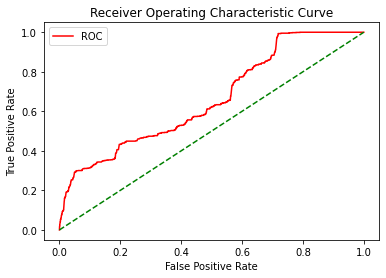

Test accuacy : 0.054051250129681504
Test Recall : 1.0
Test precision : 0.054051250129681504
Test f1-score : 0.10255905511811024
Test ROC_AUC Score : 0.6613034783026046
Time(s): 5976.114231824875
epoch =  48
D_loss : 0.6421 / G_loss : 0.6396


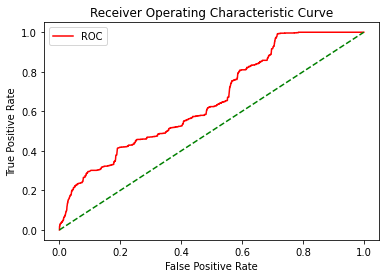

Test accuacy : 0.054051250129681504
Test Recall : 1.0
Test precision : 0.054051250129681504
Test f1-score : 0.10255905511811024
Test ROC_AUC Score : 0.6564725960208636
Time(s): 6103.606120824814
epoch =  49
D_loss : 0.6421 / G_loss : 0.6410


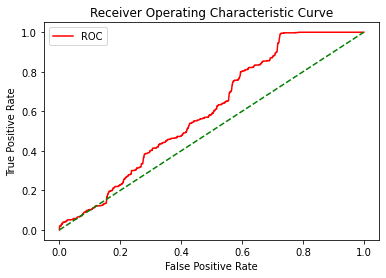

Test accuacy : 0.054051250129681504
Test Recall : 1.0
Test precision : 0.054051250129681504
Test f1-score : 0.10255905511811024
Test ROC_AUC Score : 0.6013180410476588
Time(s): 6232.799480676651
epoch =  50
D_loss : 0.6422 / G_loss : 0.6429


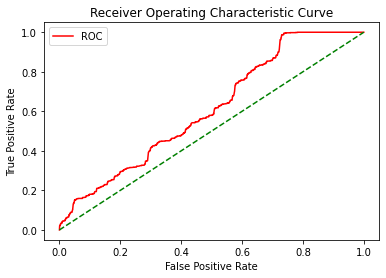

Test accuacy : 0.054051250129681504
Test Recall : 1.0
Test precision : 0.054051250129681504
Test f1-score : 0.10255905511811024
Test ROC_AUC Score : 0.6111737860905787
Time(s): 6358.979585409164


In [9]:
ADFA_model = nn.Sequential(OrderedDict([
            ('ADFA_LSTM', ADFA_LSTM(word_vector_size, ADFA_word_model.wv.vectors, n_hidden, n_step, dropout_p = drop_out)),
            ('ADFA_LINEAR', ADFA_LINEAR(n_hidden))
            ]))

ADFA_model.load_state_dict(torch.load("./lstm_weight_share_ADFA_sig_"+str(slices)+"_"+str(word_vector_size)+"d"+str(LearningRate).replace(".", "")+"LR_"+str(drop_out).replace(".","")+"Drop"+"_epoch"+str(max_epoch)+"_ignite_"+dates+"_ws_"+str(window_size)+"_layer_"+str(n_step)+"_model.model"))

ADFA_sub_model = ADFA_model.get_submodule('ADFA_LSTM')
ADFA_sub_model.eval()
ADFA_sub_model.cuda()

G = NGIDS_LSTM(word_vector_size, NGIDS_word_model.wv.vectors, n_hidden, n_step, adda_LearningRate, dropout_p = drop_out)
max_G = NGIDS_LSTM(word_vector_size, NGIDS_word_model.wv.vectors, n_hidden, n_step, adda_LearningRate, dropout_p = drop_out)

D = Discriminator(n_hidden, LearningRate = adda_LearningRate)
G.lstm.load_state_dict(ADFA_sub_model.lstm.state_dict())

G.cuda()
D.cuda()

G.train()
D.train()

torch.backends.cudnn.enabled = False

max_recall = -1

'''
G.load_state_dict(torch.load("./both_NGIDS_to_ADFA_"+str(word_vector_size)+"d_epoch"+'100'+"_ignite_"+dates+"_model.model"))
D.load_state_dict(torch.load("./both_Discriminator_"+str(word_vector_size)+"d_epoch"+'100'+"_ignite_"+dates+"_model.model"))
'''

loss_func = nn.BCELoss()
d_optim = optim.Adam(D.parameters(), lr=adda_LearningRate)
g_optim = optim.Adam(G.parameters(), lr=adda_LearningRate)

d_losses = []
g_losses = []

n_iter = min(len(ADFA_loader), len(NGIDS_train_loader))

start_time = time.time()

for epoch in range(adda_max_epoch):
    print ("epoch = ", epoch + 1)
    
    source_iter = iter(ADFA_loader)
    target_iter = iter(NGIDS_train_loader)    
    
    d_loss_sum = 0
    g_loss_sum = 0
    
    for i in range(n_iter) :
        source_data, _ = next(source_iter)
        target_data, _ = next(target_iter)
        
        if len(source_data[0]) != len(target_data[0]):
               continue
        
        D_input_source = ADFA_sub_model(source_data)
        D_input_target = G(target_data)

        D_output_source = D(D_input_source)
        D_output_target = D(D_input_target)        
        
        D_target_source = torch.tensor([1] * len(source_data[0]), dtype=torch.float32).cuda()
        D_target_target = torch.tensor([0] * len(source_data[0]), dtype=torch.float32).cuda()

        D_output = torch.cat([D_output_source, D_output_target], dim=0)
        D_target = torch.cat([D_target_source, D_target_target], dim=0)
        
        d_loss = loss_func(D_output, D_target.reshape(len(D_target), 1))
        
        d_optim.zero_grad()
        d_loss.backward()
        d_optim.step()
        
        d_loss_sum += d_loss
        
        # target train
        D_input_target = G(target_data)
        D_output_target = D(D_input_target)
        
        g_loss = loss_func(D_output_target, D_target_source.reshape(len(D_target_source), 1))
        
        g_optim.zero_grad()
        g_loss.backward()
        g_optim.step()
 
        g_loss_sum += g_loss
    

    d_loss = d_loss_sum / n_iter
    g_loss = g_loss_sum / n_iter
    
    d_losses.append(d_loss.detach().cpu())
    g_losses.append(g_loss.detach().cpu())
    
    print(f"D_loss : {d_loss:.4f} / G_loss : {g_loss:.4f}")
    recall = G_epoch_eval(G, ADFA_model, NGIDS_test_loader)
    
    end_time = time.time() - start_time
    print(f"Time(s): {end_time}")
    
    if max_recall < recall :
        max_recall = recall
        max_G.load_state_dict(G.state_dict())
        
    
torch.save(max_G.state_dict(), "./lstm_weight_NGIDS_to_ADFA_sig_"+str(slices)+"_"+str(word_vector_size)+"d_epoch"+str(adda_max_epoch)+"_ignite_"+dates+"_ws_"+str(window_size)+"_layer_"+str(n_step)+"_model.model")
torch.save(D.state_dict(), "./lstm_weight_Discriminator_sig_"+str(slices)+"_"+str(word_vector_size)+"d_epoch"+str(adda_max_epoch)+"_ignite_"+dates+"_ws_"+str(window_size)+"_layer_"+str(n_step)+"_model.model")

In [10]:
# plt.plot(d_losses, label='d_loss')
# plt.legend()
# plt.xlabel('epoch', fontsize=12)
# plt.ylabel('loss', fontsize=12)
# plt.title("D loss value graph", fontsize=14)
# plt.show()

# plt.plot(g_losses, label='g_loss')
# plt.legend()
# plt.xlabel('epoch', fontsize=12)
# plt.ylabel('loss', fontsize=12)
# plt.title("G loss value graph", fontsize=14)
# plt.show()


In [ ]:
# import numpy as np
# from sklearn.metrics import roc_curve
# y = np.array([1, 1, 2, 2])
# scores = np.array([0.1, 0.8,0.9,0.8])

# plt.figure()
# lw = 2
# plt.plot(
#     fpr,
#     tpr,
#     color="darkorange",
#     lw=lw,
# )
# plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel("False Positive Rate")
# plt.ylabel("True Positive Rate")
# plt.title("Receiver operating characteristic example")
# plt.legend(loc="lower right")
# plt.show()